## Collaborative Filtering

##### Implicit
So far we have only worked with implicit recommendations and so we need to convert the ratings/interactions to values 0/1. One way to do that is just setting everything a user rated as a interaction and try and predict if a user is likely to watch a movie, but give no indication about if they will like it or not.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from tqdm import tqdm, trange
from torch.autograd import Variable
from sklearn.manifold import TSNE
import sys
sys.path.append("../")

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
from youchoose.data.data_loading import InteractionsDataset
from youchoose.extraction.nn_latent_matrix_factorization import MatrixFactorization
from youchoose.visualization.visualize import scatter, embedding_tsne

In [4]:
# movie rating dataset
df = pd.read_csv("../data/ml-latest-small/ratings.csv")
col_names = df.columns
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# subsample dataset for smaller training
all_ = len(df)
dataframe = df.sample(all_, random_state=23)  # here we are only taking 500 interactions

In [6]:
epochs = 50
print_every = 5
embedding_dim = 25
l2 = 0.001
lr = 0.01
loss_fn = nn.MSELoss
num_negs = 0
bs = 250

(tr_load, va_load, te_load), n_users, n_prod = InteractionsDataset.ratings_dataloader(
    dataframe,
    user_col=col_names[0],
    item_col=col_names[1],
    weight_col=col_names[2],
    batch_size=bs,
    dev=dev,
    num_negs=num_negs,
    shuffle_train=True,
    reweight=True,
    train_frac=0.80,
    test_frac=0.10,
)

In [7]:
model = MatrixFactorization(
        n_users, n_prod, n_factors=embedding_dim, lr=lr, l2=l2, loss_fn=loss_fn
    ).to(dev)

In [8]:
model.create_user_item_array()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [19]:
for epoch in trange(epochs):
    train_loss, train_accuracy = model.train_model(tr_load)
    val_loss, val_accuracy = model.evaluate(va_load)

    if (epoch + 1) % print_every == 0:
        print(
            f"epoch #{epoch + 1}, "
            f"training loss: {train_loss:0.3f}, "
            f"training accuracy: {train_accuracy}, "
            f"validation loss: {val_loss:0.3f}, "
            f"validation accuracy: {val_accuracy}, "
        )

  4%|▍         | 2/50 [00:27<11:09, 13.95s/it]

KeyboardInterrupt: 

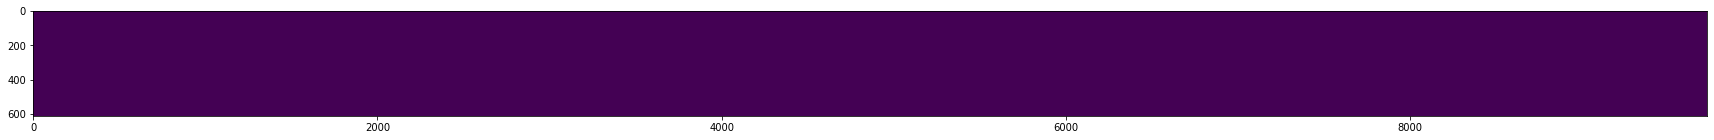

In [9]:
plt.figure(figsize=(30,20))
plt.imshow(model.create_user_item_array().T)

In [10]:
import itertools as it
train_loss = 0
total=0
correct=0
for user, item, rating in it.islice(tr_load, 2):
    model.optimizer.zero_grad()

    forward = model(user, item)
    predicted = model._prob_to_class(forward)
    loss = model.loss(forward, rating)

    train_loss += loss.item()
    total += predicted.numel()
    correct += (predicted == rating).sum().item()


In [18]:
forward = model(user, item)
predict_pos = model.activation(forward)
predict_neg = 1 - predict_pos
torch.stack((predict_neg, predict_pos)).argmax(0)#.float()

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1])

In [ ]:
if 1:
    item_emb = model.product_factors(item) + model.product_bias(item)
    user_emb = model.user_factors(user) + model.user_bias(user)
    mat_mult = (item_emb * user_emb).sum(1)

In [ ]:
user_em = model.user_factors.weight.detach()
item_em = model.product_factors.weight.detach()
user_b = model.user_bias.weight.detach()
item_b = model.product_bias.weight.detach()

user_item_array = ((item_em + item_b) @ (user_em + user_b).transpose(0,1))
post_probs = model.activation(user_item_array).numpy()
post_preds = model._prob_to_class(user_item_array).numpy()

post_movie_tsne = TSNE(random_state=23).fit_transform(model.product_factors.weight.detach().numpy())
post_user_tsne = TSNE(random_state=23).fit_transform(model.user_factors.weight.detach().numpy())

embedding_tsne(post_movie_tsne, post_user_tsne, ["movies", "users"])
plt.show()

In [ ]:
embedding_tsne(pre_user_tsne, post_user_tsne, ["pre user", "post users"])
embedding_tsne(pre_movie_tsne, post_movie_tsne, ["pre movies", "post movie"])

In [ ]:
def recommend_item_for_user(model, user_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in [user_id] * len(items)])
    item_ids = torch.LongTensor([item2idx[b] for b in items])

    remove = set(ratings[ratings[user_col] == user_id][item_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_item = [
        (p, b) for p, b in sorted(zip(preds, items), reverse=True) if b not in remove
    ]

    return pred_item


def recommend_user_for_item(model, item_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in users])
    book_ids = torch.LongTensor([item2idx[b] for b in [item_id] * len(users)])

    remove = set(ratings[ratings[item_col] == book_id][user_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_user = [
        (p, u) for p, u in sorted(zip(preds, users), reverse=True) if u not in remove
    ]

    return pred_user

In [ ]:
USE_WEIGHTS = False

if USE_WEIGHTS and Path("nn_model_epoch_1.pth").exists():
    model_save = torch.load("nn_model_epoch_1.pth")

    # before training user-item interaction matrix
    user_em = model_save["user_factors.weight"]
    item_em = model_save["product_factors.weight"]
    user_b = model_save["user_bias.weight"]
    item_b = model_save["product_bias.weight"]

    user_item_array = ((item_em + item_b) @ (user_em + user_b).transpose(0,1))
    pre_probs = model.activation(user_item_array).numpy()
    pre_preds = model._prob_to_class(user_item_array).numpy()

    pre_movie_tsne = TSNE(random_state=23).fit_transform(item_em)
    pre_user_tsne = TSNE(random_state=23).fit_transform(user_em)

    f, (ax1, ax2) = embedding_tsne(pre_movie_tsne, pre_user_tsne, ["movies", "users"])
    plt.show()